In [112]:
from pulp import LpProblem, LpVariable, LpMaximize, LpStatus, lpSum, value
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import math
import seaborn as sns
import time
import japanize_matplotlib

In [89]:
# Read files
files = glob('../*/*coupon/*.csv')
cust_df = pd.read_csv(files[0])
prob_df = pd.read_csv(files[1])
# print(files)
# print(cust_df.shape)
# print(prob_df.shape)
display(cust_df.head(3))
display(prob_df.head(3))

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0


,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74


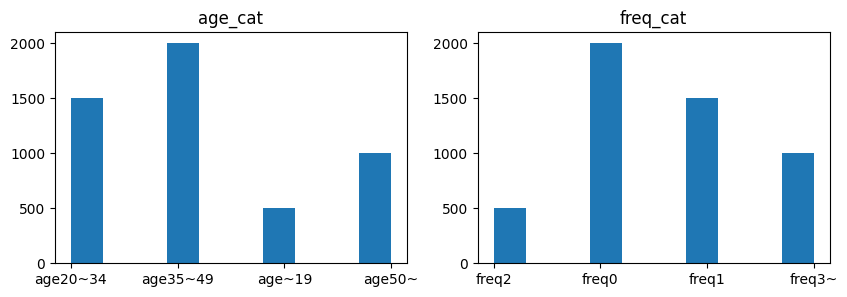

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].hist(cust_df['age_cat'])
axs[0].set_title('age_cat')
axs[1].hist(cust_df['freq_cat'])
axs[1].set_title('freq_cat')
plt.show()

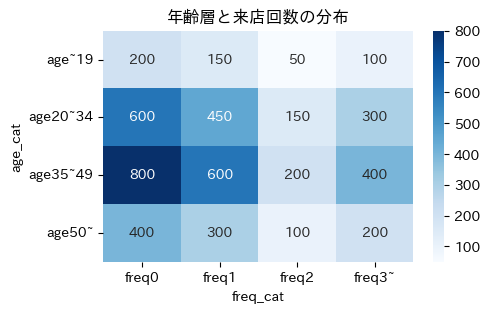

In [114]:
plt.figure(figsize=(5, 3))
pivot_df = pd.pivot_table(data=cust_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
pivot_df = pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
sns.heatmap(pivot_df, annot=True, fmt='d', cmap='Blues')
plt.title('年齢層と来店回数の分布')
plt.show()

In [119]:
previous_column = ['customer_id', 'age_cat', 'freq_cat', 'segment_id', 'prob_dm1', 'prob_dm2', 'prob_dm3']
modified_column = ['id', 'age', 'freq', 'seg_id', 'prob_1', 'prob_2', 'prob_3']
columns = {pc: mc for i, (pc, mc) in enumerate(zip(previous_column, modified_column))}
columns

{'customer_id': 'id',
 'age_cat': 'age',
 'freq_cat': 'freq',
 'segment_id': 'seg_id',
 'prob_dm1': 'prob_1',
 'prob_dm2': 'prob_2',
 'prob_dm3': 'prob_3'}

In [126]:
# データフレームの結合
cust_prob_df = pd.merge(cust_df, prob_df, on=['age_cat', 'freq_cat'])
print(cust_prob_df.columns)
print(cust_prob_df.shape)

# カラム名の修正
modified_column = ['id', 'age', 'freq', 'seg_id', 'prob_1', 'prob_2', 'prob_3']
columns = {pc: mc for pc, mc in zip(cust_prob_df.columns, modified_column)}
cust_prob_df = cust_prob_df.rename(columns=columns) 

# データの整理(見やすく)
def string_substitution(x):
    tralslate_dict = {
        'age20~34': '20', 'age35~49': '35', 'age~19': '19', 'age50~': '50',
        'freq0': '0', 'freq1': '1', 'freq2': '2', 'freq3~': '3',
    }
    return tralslate_dict[x]

cust_prob_df['age'] = cust_prob_df['age'].apply(string_substitution)
cust_prob_df['freq'] = cust_prob_df['freq'].apply(string_substitution)

# 確率の差を計算
for i in range(3):
    cust_prob_df[f'prob_(1-{i+1})'] = cust_prob_df[f'prob_{i+1}'] - cust_prob_df['prob_1']

cust_prob_df.head()

Index(['customer_id', 'age_cat', 'freq_cat', 'segment_id', 'prob_dm1',
       'prob_dm2', 'prob_dm3'],
      dtype='object')
(5000, 7)


,id,age,freq,seg_id,prob_1,prob_2,prob_3,prob_(1-1),prob_(1-2),prob_(1-3)
0,1,20,2,7,0.42,0.55,0.93,0.0,0.13,0.51
1,2,35,0,9,0.08,0.14,0.33,0.0,0.06,0.25
2,3,35,0,9,0.08,0.14,0.33,0.0,0.06,0.25
3,4,19,0,1,0.07,0.12,0.29,0.0,0.05,0.22
4,5,35,0,9,0.08,0.14,0.33,0.0,0.06,0.25


In [93]:
# dmごとに縦に結合 dm列、コスト列追加
COSTS = {1 : 0, 2 : 1000, 3 : 2000}

p_df = pd.DataFrame()
for i in range(3):
    tmp_df = cust_prob_df[['id', 'age', 'freq', 'seg_id', f'prob_{i+1}', f'prob_(1-{i+1})']].copy()
    tmp_df = tmp_df.rename(columns={f'prob_{i+1}': 'prob', f'prob_(1-{i+1})': 'prob_diff'})
    tmp_df['dm'] = i+1
    tmp_df['cost'] = tmp_df['dm'].apply(lambda x: COSTS[x])
    p_df = pd.concat([p_df, tmp_df], axis=0)

print(p_df.shape)
p_df.sort_values(['id', 'dm'], inplace=True)
p_df[(p_df['id'] == 1) | (p_df['id'] == 2)]

(15000, 8)


,id,age,freq,seg_id,prob,prob_diff,dm,cost
0,1,20,2,7,0.42,0.00,1,0
0,1,20,2,7,0.55,0.13,2,1000
0,1,20,2,7,0.93,0.51,3,2000
1,2,35,0,9,0.08,0.00,1,0
1,2,35,0,9,0.14,0.06,2,1000
1,2,35,0,9,0.33,0.25,3,2000


In [94]:
# 変数定義
p_df['variable'] = [LpVariable(name=f'id{id:04}_dm{dm}', cat='Binary') for id, dm in zip(p_df['id'], p_df['dm'])]
p_df.head(5)

,id,age,freq,seg_id,prob,prob_diff,dm,cost,variable
0,1,20,2,7,0.42,0.00,1,0,id0001_dm1
0,1,20,2,7,0.55,0.13,2,1000,id0001_dm2
0,1,20,2,7,0.93,0.51,3,2000,id0001_dm3
1,2,35,0,9,0.08,0.00,1,0,id0002_dm1
1,2,35,0,9,0.14,0.06,2,1000,id0002_dm2


In [95]:
# Maximize
problem = LpProblem('Discount_Coupon_Problem', sense=LpMaximize)

# Maximize visitor rates by coupons
problem += lpSum(p_df['variable'] * p_df['prob_diff'])

# There is always one assignment
for k, v in p_df.groupby('id'):
    problem += lpSum(v['variable']) == 1

# Below a certain amount
BUDGET_LIMIT = 1000000
problem += lpSum(p_df['variable']* p_df['prob'] * p_df['cost']) <= BUDGET_LIMIT

# segment_each_member_rate_10_percent_or_more
for k, v in p_df.groupby(['seg_id', 'dm']):
    problem += lpSum(v['variable']) >= 0.1 * v.shape[0]

# problem

In [96]:
# 計算及び結果
time_start = time.time()
status = problem.solve()
time_stop = time.time()

p_df['result'] = p_df['variable'].apply(value)

print(f'Status : {LpStatus[status]}')
print(f'Result : {value(problem.objective):.04f}')
print(f'Time : {time_stop - time_start:.03} (sec)')

Status : Optimal
Result : 326.0900
Time : 2.82 (sec)


In [97]:
p_df.head()

,id,age,freq,seg_id,prob,prob_diff,dm,cost,variable,result
0,1,20,2,7,0.42,0.00,1,0,id0001_dm1,1.0
0,1,20,2,7,0.55,0.13,2,1000,id0001_dm2,0.0
0,1,20,2,7,0.93,0.51,3,2000,id0001_dm3,0.0
1,2,35,0,9,0.08,0.00,1,0,id0002_dm1,0.0
1,2,35,0,9,0.14,0.06,2,1000,id0002_dm2,1.0


In [98]:
# すべてのセグメントにおいて合計 1
for k, v in p_df.groupby('id'):
    print(v['result'].sum(), end=', ')
    if k % 30 == 0:
        print()

1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 
1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [99]:
# 予算 1,000,000 以下
(p_df['result'] * p_df['prob'] * p_df['cost']).sum()

999990.0

In [100]:
# 各dm 10% 以上
i = 0
for k, v in p_df.groupby(['seg_id', 'dm']):
    rate = v['result'][v['result']== 1].count() / v['result'].count()
    print(f'{rate:.03f}', end=', ')
    if i % 10 == 9:
        print()
    i += 1

0.100, 0.795, 0.105, 0.800, 0.100, 0.100, 0.800, 0.100, 0.100, 0.800, 
0.100, 0.100, 0.800, 0.100, 0.100, 0.800, 0.100, 0.100, 0.800, 0.100, 
0.100, 0.800, 0.100, 0.100, 0.100, 0.800, 0.100, 0.800, 0.100, 0.100, 
0.800, 0.100, 0.100, 0.800, 0.100, 0.100, 0.100, 0.280, 0.620, 0.800, 
0.100, 0.100, 0.800, 0.100, 0.100, 0.800, 0.100, 0.100, 

In [101]:
# 結果
result_df = cust_prob_df.copy()
for i in range(p_df['dm'].nunique()):
    result_df[f'send_dm{i+1}'] = p_df[(p_df['dm'] == i+1)]['result']
result_df.head()

,id,age,freq,seg_id,prob_1,prob_2,prob_3,prob_(1-1),prob_(1-2),prob_(1-3),send_dm1,send_dm2,send_dm3
0,1,20,2,7,0.42,0.55,0.93,0.0,0.13,0.51,1.0,0.0,0.0
1,2,35,0,9,0.08,0.14,0.33,0.0,0.06,0.25,0.0,1.0,0.0
2,3,35,0,9,0.08,0.14,0.33,0.0,0.06,0.25,0.0,1.0,0.0
3,4,19,0,1,0.07,0.12,0.29,0.0,0.05,0.22,0.0,1.0,0.0
4,5,35,0,9,0.08,0.14,0.33,0.0,0.06,0.25,0.0,1.0,0.0


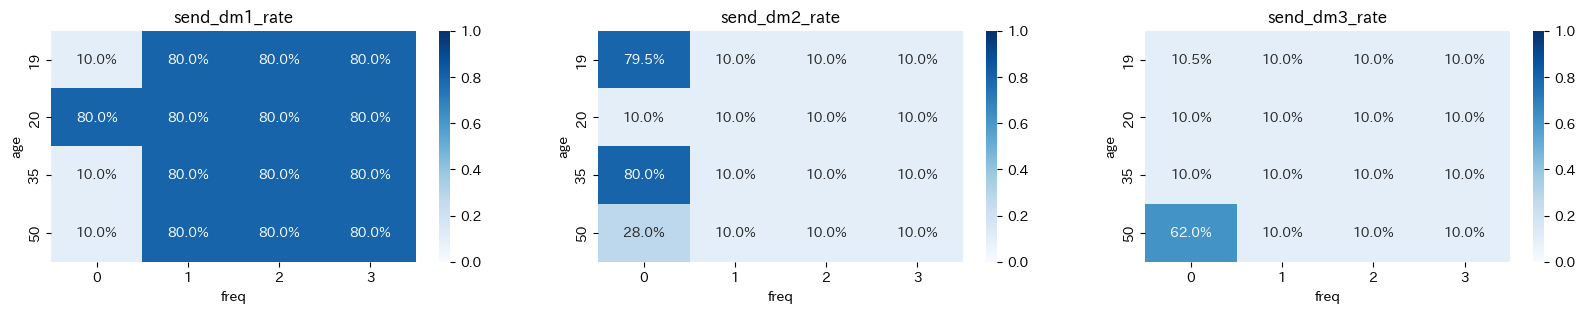

In [127]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    send_dm_df = pd.pivot_table(data=result_df, values=ptn, columns='freq', index='age', aggfunc='mean')
    sns.heatmap(send_dm_df, vmin=0, vmax=1, annot=True, fmt='.1%', cmap='Blues', ax=axs[i])
    axs[i].set_title(f'{ptn}_rate')
plt.show()

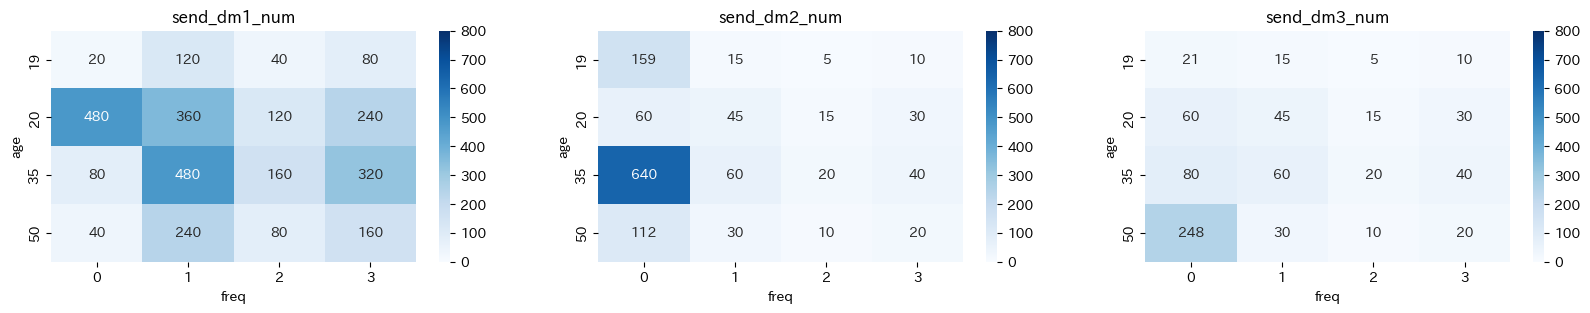

In [128]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=result_df, values=ptn, columns='freq', index='age', aggfunc='sum')
    sns.heatmap(cust_send_pivot_df, vmin=0, vmax=800, annot=True, fmt='.0f', cmap='Blues', ax=axs[i])
    axs[i].set_title(f'{ptn}_num')
plt.show()